# Discrete Choice Modeling

For more detailed information, please see: 

Koppelman & Bhat (2006) A Self-Instructing Course in Mode Choice Modeling
http://www.caee.utexas.edu/prof/bhat/COURSES/LM_Draft_060131Final-060630.pdf 


### Motivation

Not everything has a continous dependent variable.  Some things are discrete.  Coke or Pepsi?  Soda or pop?  Let's think of a few...

Discrete choice models give us a way to model this.  


### Elements

In this framework, there are several elements to the choice decision process: 

- The decision maker
- The alternatives
- Attributes of the alternatives
- The decision rule


### Structure and Assumptions

We will use a multi-nomial logit (MNL) model.  It takes the form: 

$Pr(i) = \frac{e^{U_i}}{\sum_{j=1}^{J} e^{U_j}}$

where $U_i = \beta X_i + \epsilon_i$ and $\epsilon_i$ follows a Gumbel distribution. 

This equation defines the decision rule.  A bit of time to work it through...

### Libraries

Will be using [Statsmodels](http://statsmodels.sourceforge.net/).  Start with: 

    conda install statsmodels
    
    

### Today's objective

Today, we want to predict vehicle ownership.  

We'll be using the PUMS data again.  This time we'll use the household records instead of the person records, and households will be our decision-making unit.  You can find the data here: 

https://www.census.gov/programs-surveys/acs/data/pums.html

Please download the Kentucky 1-year household data.  

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf

# this allows plots to appear directly in the notebook
%matplotlib inline

In [2]:
# get the data
df = pd.read_csv('data/psam_h21.csv')
df.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,WGTP71,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80
0,H,2017000000006,6,2400,3,21,1000000,1011189,79,1,...,109,26,126,85,111,68,34,73,28,105
1,H,2017000000109,6,1703,3,21,1000000,1011189,12,1,...,24,21,3,5,13,15,13,13,26,5
2,H,2017000000131,6,1500,3,21,1000000,1011189,273,2,...,106,510,305,244,287,502,271,90,341,103
3,H,2017000000185,6,2400,3,21,1000000,1011189,65,1,...,18,88,80,105,126,61,68,64,54,18
4,H,2017000000265,6,300,3,21,1000000,1011189,130,1,...,127,120,235,102,136,215,181,194,143,127


In [3]:
# keep only occupied housing units
'''
NP 2
Number of person records following this housing record
00 .Vacant unit
01 .One person record (one person in household or any person in
.group quarters)
02..20 .Number of person records (number of persons in household)

TYPE 1
Type of unit
1 .Housing unit
2 .Institutional group quarters
3 .Noninstitutional group quarters
'''

df = df[df['TYPE']==1]
df = df[df['NP']>0]
len(df)

18104

### Look at the data

It is often a good idea to look at the data we want to model, and see how it relates to some variables we expect to be important.  We can do this using seaborn, which we learned about a few weeks ago.  

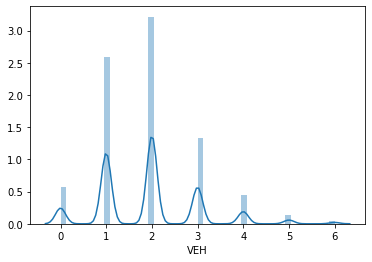

In [4]:
'''
10
VEH 1
Vehicles (1 ton or less) available
b .N/A (GQ/vacant)
0 .No vehicles
1 .1 vehicle
2 .2 vehicles
3 .3 vehicles
4 .4 vehicles
5 .5 vehicles
6 .6 or more vehicles
'''

sns.distplot(df['VEH'])

In [5]:
# there aren't very many above 3, so group all of those
df['VEH'] = df['VEH'].apply(lambda x : min(x, 3))
df['VEH'] = df['VEH'].astype(int)

# sns.distplot(df['VEH'])

### Estimating a model

OK, that's fine, we can do plots, but we want some actual numbers.  For this, we want to estimate what the model coefficients are. 

In [6]:
# Here is the constants only model. 
mod = smf.mnlogit(formula='VEH ~ 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.254790
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                18104
Model:                        MNLogit   Df Residuals:                    18101
Method:                           MLE   Df Model:                            0
Date:                Tue, 31 Mar 2020   Pseudo R-squ.:               8.016e-11
Time:                        22:56:29   Log-Likelihood:                -22717.
converged:                       True   LL-Null:                       -22717.
Covariance Type:            nonrobust   LLR p-value:                       nan
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5096      0.031     48.108      0.000       1.448       1.571
-----------------------------

Notice a few things: 

1. Goodness of fit measures
2. Separate coefficients for each alternative

In [7]:
# That's fine, but we may try some more things.  Perhaps age matters. 
# More people -> more cars? 

mod = smf.mnlogit(formula='VEH ~ NP + 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.144302
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                18104
Model:                        MNLogit   Df Residuals:                    18098
Method:                           MLE   Df Model:                            3
Date:                Tue, 31 Mar 2020   Pseudo R-squ.:                 0.08805
Time:                        22:56:34   Log-Likelihood:                -20716.
converged:                       True   LL-Null:                       -22717.
Covariance Type:            nonrobust   LLR p-value:                     0.000
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4446      0.073     19.677      0.000       1.301       1.588
NP             0.0389      0.

We can apply this model

### Categorical variables

We may also want to include categorical variables.  We can include them by calculating a 'dummy' variable, which is 1 if the value is in a category, and zero otherwise.  

In [8]:
'''
HUPAC 1
HH presence and age of children
b .N/A (GQ/vacant)
1 .With children under 6 years only
2 .With children 6 to 17 years only
3 .With children under 6 years and 6 to 17 years
4 .No children
'''

dummies = pd.get_dummies(df['HUPAC'])
dummies.columns = ['kids_u6', 'kids_6_17', 'kids_u6_and_617', 'no_kids']
df = df.join(dummies)
df.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80,kids_u6,kids_6_17,kids_u6_and_617,no_kids
0,H,2017000000006,6,2400,3,21,1000000,1011189,79,1,...,111,68,34,73,28,105,0,0,0,1
1,H,2017000000109,6,1703,3,21,1000000,1011189,12,1,...,13,15,13,13,26,5,0,0,0,1
2,H,2017000000131,6,1500,3,21,1000000,1011189,273,2,...,287,502,271,90,341,103,0,0,0,1
3,H,2017000000185,6,2400,3,21,1000000,1011189,65,1,...,126,61,68,64,54,18,0,0,0,1
4,H,2017000000265,6,300,3,21,1000000,1011189,130,1,...,136,215,181,194,143,127,0,0,0,1


In [9]:
# That's fine, but we may try some more things.  Perhaps age matters. 
# More people -> more cars? 

mod = smf.mnlogit(formula='VEH ~ NP + kids_u6 + kids_6_17 + kids_u6_and_617 + 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.100462
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                18104
Model:                        MNLogit   Df Residuals:                    18089
Method:                           MLE   Df Model:                           12
Date:                Tue, 31 Mar 2020   Pseudo R-squ.:                  0.1230
Time:                        22:57:08   Log-Likelihood:                -19923.
converged:                       True   LL-Null:                       -22717.
Covariance Type:            nonrobust   LLR p-value:                     0.000
          VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.5788      0.086     18.351      0.000       1.410       1.747
NP            

In [ ]:
# what else should we add? 

### Homework

Calculate the probability that a 1-person household in Lexington, earning $16,000 per year owns 0, 1, 2 or 3+ vehicles.  

In [3]:
df.columns

Index(['RT', 'SERIALNO', 'DIVISION', 'PUMA', 'REGION', 'ST', 'ADJHSG',
       'ADJINC', 'WGTP', 'NP',
       ...
       'WGTP71', 'WGTP72', 'WGTP73', 'WGTP74', 'WGTP75', 'WGTP76', 'WGTP77',
       'WGTP78', 'WGTP79', 'WGTP80'],
      dtype='object', length=230)

In [6]:
# there aren't very many above 3, so group all of those
df['VEH'] = df['VEH'].apply(lambda x : min(x, 3))
df['VEH'] = df['VEH'].astype(int)

In [7]:
# segregate KY state in the PUMS data and later extract Lexington using PUMAs = 1901 or 1902
df2 = df[(df['ST']==21) & (df["PUMA"].isin([1901,1902]))]

In [17]:
df["VEH"]

0        2.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
19836    3.0
19837    2.0
19838    2.0
19840    3.0
19841    2.0
Name: VEH, Length: 18104, dtype: float64

In [8]:
mod = smf.mnlogit(formula='VEH ~ NP + FINCP + 1', data=df2)
res=mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.949217
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                  730
Model:                        MNLogit   Df Residuals:                      721
Method:                           MLE   Df Model:                            6
Date:                Thu, 02 Apr 2020   Pseudo R-squ.:                  0.1179
Time:                        12:13:21   Log-Likelihood:                -692.93
converged:                       True   LL-Null:                       -785.52
Covariance Type:            nonrobust   LLR p-value:                 2.687e-37
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7030      0.752      4.923      0.000       2.229       5.177
NP            -0.4421      0.

In [9]:
mod = smf.mnlogit(formula='VEH ~ NP + HINCP + 1', data=df2)
res=mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.001371
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                 1253
Model:                        MNLogit   Df Residuals:                     1244
Method:                           MLE   Df Model:                            6
Date:                Thu, 02 Apr 2020   Pseudo R-squ.:                  0.1799
Time:                        12:13:26   Log-Likelihood:                -1254.7
converged:                       True   LL-Null:                       -1530.0
Covariance Type:            nonrobust   LLR p-value:                1.022e-115
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9030      0.289      3.128      0.002       0.337       1.469
NP            -0.2148      0.